# Natural language processing : a case study.  

On this notebook we apply some basic NLP techniques : clustering, topic modeling, and text classification principles.
This case study is based on the Reuters-21578 dataset, wich is a collection of documents that appeared on Reuters newswire in 1987. The documents were assembled and indexed with categories (Data from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Reuters-21578+Text+Categorization+Collection))

Ref. [Deep Learning for NLP and Speech Recognition](https://www.springer.com/gp/book/9783030145958) book by Uday Kamath, John Liu  and James Whitaker.


# Setup

In [323]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


import re

import nltk 
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.decomposition import PCA
from sklearn.preprocessing.label import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


from tensorflow import keras

# Load the data

In [2]:
filelist = ['reuters-000.json',
            'reuters-001.json',
            'reuters-002.json',
            'reuters-003.json',
            'reuters-004.json',
            'reuters-005.json',
            'reuters-006.json',
            'reuters-007.json',
            'reuters-008.json',
            'reuters-009.json',
            'reuters-010.json',
            'reuters-011.json',
            'reuters-012.json',
            'reuters-013.json',
            'reuters-014.json',
            'reuters-015.json',
            'reuters-016.json',
            'reuters-017.json',
            'reuters-018.json',
            'reuters-019.json',
            'reuters-020.json',
            'reuters-021.json']
data_set = pd.DataFrame()
for fname in filelist:
  df = pd.read_json('data/reuters-21578-json/'+fname).T
  data_set = data_set.append(df)
  
data_set = data_set.fillna('')
print("Done!") 

Done!


In [3]:
data_set.head()

,title,body,date,topics,places,organisations
1,BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...,26-FEB-1987 15:01:01.79,[cocoa],"[el-salvador, usa, uruguay]",
2,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America\nInc said...,26-FEB-1987 15:02:20.00,,[usa],
3,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas\nCommerc...,26-FEB-1987 15:03:27.51,,[usa],
4,TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,BankAmerica Corp is not under\npressure to act...,26-FEB-1987 15:07:13.72,,"[usa, brazil]",
5,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...,26-FEB-1987 15:10:44.60,"[grain, wheat, corn, barley, oat, sorghum]",[usa],


In [4]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21578 entries, 1 to 21578
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          21578 non-null  object
 1   body           21578 non-null  object
 2   date           21578 non-null  object
 3   topics         21578 non-null  object
 4   places         21578 non-null  object
 5   organisations  21578 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


# Exploratory Data Analysis

Extracting metadata and the text bodyfrom each document in the corpus.

In [5]:
topics =set([x for sublist in data_set['topics'].values.tolist() for x in sublist])
places = set([x for sublist in data_set['places'].values.tolist() for x in sublist])
orgs = set([x for sublist in data_set['organisations'].values.tolist() for x in sublist])

In [6]:
data_set['topic_count']=data_set['topics'].apply(lambda x:len([y for y in x]))

#data_set['organisations'].apply(tuple).value_counts()[1:15].plot(kind='bar',title="Document Count by Organization")


In [7]:
print("documents with at least one topic = ",len(data_set[data_set['topic_count']>0]))
print("max number of topics in one document = ",data_set['topic_count'].max())
print('topics = ',len(topics))
print('places = ',len(places))
print('organizations = ',len(orgs))

documents with at least one topic =  11367
max number of topics in one document =  16
topics =  120
places =  147
organizations =  32


In [87]:
def plot_document_count(data_set, by='organisations', id_min=1, id_max=15, message='' ):
    docs = data_set[by].apply(tuple).value_counts()[id_min:id_max].reset_index()
    docs.rename(columns={'index':by, by:'Document Count'}, inplace=True)
    sns.barplot(x=by, y='Document Count', data=docs)
    plt.xticks(rotation=60)
    plt.title('Document Count by '+ by + ' ' +message)

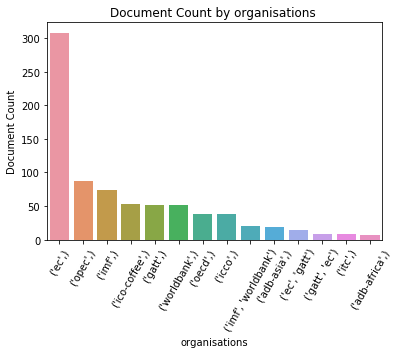

In [88]:
plot_document_count(data_set,by='organisations')

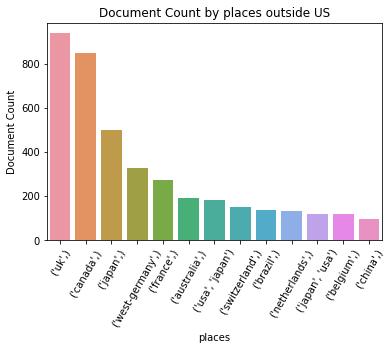

In [91]:
plot_document_count(data_set,by='places', id_min=2, id_max=15, message='outside US')

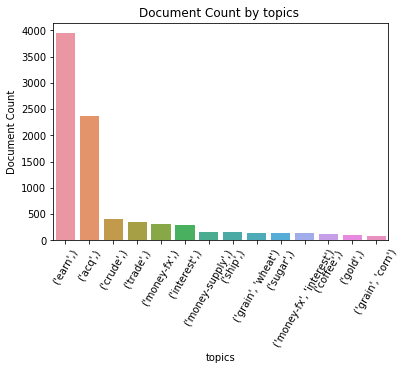

In [92]:
plot_document_count(data_set,by='topics', id_min=1, id_max=15)

# Text normalization

* transform to lower case
* remove punctuation & numbers
* remove stopwords
* stem verbs 

In [93]:
nltk.download('punkt')
nltk.download('stopwords', 'data')
nltk.data.path.append('data')

[nltk_data] Downloading package punkt to /Users/kaci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to data...
[nltk_data]   Package stopwords is already up-to-date!


In [318]:
ml_binarizer = MultiLabelBinarizer()
data_target = ml_binarizer.fit_transform(data_set['topics'])

stopWords = stopwords.words('english')

charfilter = re.compile('[a-zA-Z]+');

def SimpleTokenizer(text):
    #tokenization & remove punctuation
    words = map(lambda word: word.lower(), word_tokenize(text))
    #Remouve stop words
    words = [word for word in words if word not in stopWords]
    #Stemming (remove morphological affixes from tokens)
    tokens = (list(map(lambda token: PorterStemmer().stem(token),words)))
    #remove numbers
    ntokens = list(filter(lambda token:charfilter.match(token),tokens))
    return ntokens

tfdid_vec = TfidfVectorizer(tokenizer=SimpleTokenizer,
                        max_features=1000,
                        norm='l2')

mytopics = ['cocoa','trade','money-supply','coffee','gold']
data_set = data_set[data_set['topics'].map(set(mytopics).intersection).apply(lambda x: len(x)>0)]
docs = list(data_set['body'].values)

dtm = tfdid_vec.fit_transform(docs)

print("Dimension of the TFIDF sparse matrix : (n_samples, n_features) = ", dtm.shape)


Dimension of the TFIDF sparse matrix : (n_samples, n_features) =  (1076, 1000)


# Text Clustering

Dimensionality reduction with rincipal Component Analysis (PCA).

Text(0, 0.5, 'Proportion of Explained Variance')

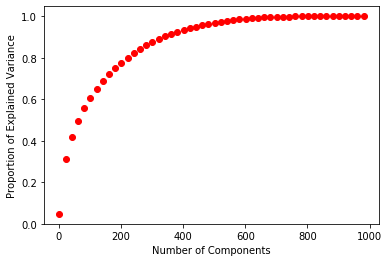

In [309]:
explained_var = []
for components in range(1,1000,20):
    pca = PCA(n_components=components)
    pca.fit(dtm.toarray())
    explained_var.append(pca.explained_variance_ratio_.sum())

plt.plot(range(1,1000,20),explained_var,"ro")
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Explained Variance")

The graph above shows that half of the variance an be explained by 65 components.
Let's plot the first two PCA components of each document.

Explained variance of the PCA step: 51%


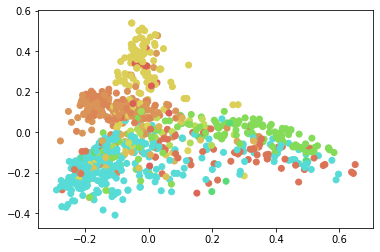

In [333]:
components = 65

palette = np.array(sns.color_palette("hls", 120))

pca = PCA(n_components=components)
#pca.fit(dtm.toarray())
pca_dtm = pca.fit_transform(dtm.toarray())
data_target = ml_binarizer.fit_transform(data_set['topics'])
plt.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[data_target.argmax(axis=1).astype(int)])

explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA step: {}%".format(
    int(explained_variance * 100)))

Let's examine document grouping by KMeans algorythm with k=5 (we know that there are 5 distinct topics )

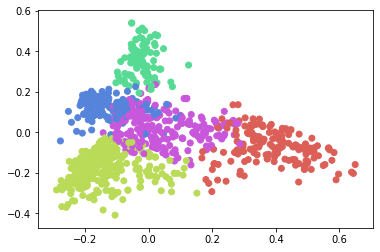

In [336]:
palette = np.array(sns.color_palette("hls", 5))

model = KMeans(n_clusters=5,max_iter=100)
clustered = model.fit(pca_dtm)
centroids = model.cluster_centers_
y = model.predict(pca_dtm)

ax = plt.subplot()
sc = ax.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[y.astype(np.int)])

 Let's compare with the manual labels.

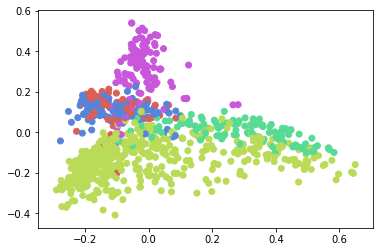

In [337]:
palette = np.array(sns.color_palette("hls", 5))

gold_labels = data_set['topics'].map(set(mytopics).intersection).apply(lambda x: x.pop()).apply(lambda x: mytopics.index(x))

ax = plt.subplot()
sc = ax.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[gold_labels])

We note that with only capturing 50% of the variance, the clustering is fairly good! 

# Topic Modeling